In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import tqdm
import torch
import torch.nn as nn
import dgl

Using backend: pytorch


In [2]:
import sys
sys.path.append("../PhenixML/")

In [3]:
# get molecules
from pathlib import Path
mol_dir = Path("/dev/shm/cschlick/geostd_passed")
#mol_dir = Path("/dev/shm/cschlick/csd_passed/")
mol_files = [file for file in mol_dir.glob("**/*") if file.suffix == ".mol"][:1000]
print("Total MOL2 files:",len(mol_files))


Total MOL2 files: 1000


In [4]:
from phenixml.fragments.fragments import ModelContainer, Fragment
containers = [ModelContainer.from_file_name(file,removeHs=True) for file in mol_files]
container = containers[0]

In [5]:
frag_name = "n3"
node_name = "n1"
connect_name = "neighbors"

In [6]:
from phenixml.utils.rdkit_utils import enumerate_angles, enumerate_bonds, enumerate_torsions
from phenixml.fragments.fragments import Fragment, ModelContainer
import itertools


class FragmenterBase:
  """
  Base class to generate molecular fragments from a molecule container
  """
  def __init__(self):
    pass
  
  def __call__(self,obj):
    return self.fragment(obj)
  
  def fragment(self,container):
    raise NotImplementedError
    
    

class BondFragmenter(FragmenterBase):
  """
  Return the bonded pair fragments for a molecule
  """

  def fragment(self,container):
    assert isinstance(container,ModelContainer)
    
    
    # rdkit
    idxs = enumerate_bonds(container.rdkit_mol)
    fragments = [Fragment(container,atom_selection=idx) for idx in idxs]
    return fragments
    
class AngleFragmenter(FragmenterBase):
  """
  Return the angle fragments for a molecule
  """
  

    
  def fragment(self,container):
    assert isinstance(container,ModelContainer)
    
    
    # rdkit
    angle_idxs = enumerate_angles(container.rdkit_mol)
    fragments = [Fragment(container,atom_selection=angle_idx) for angle_idx in angle_idxs]
    return fragments
  
  


In [7]:
from rdkit import Chem
from rdkit.Chem import rdMolTransforms

class FragLabelerBase:
  def __init__(self,name="label"):
    self.name = label
  
  def __call__(self,obj):
    return self.label(obj)
  
  def label(self,obj):
    raise NotImplementedError


class AngleFragLabeler(FragLabelerBase):
  """
  Return the angle of three atoms in a fragment.
  """
  
  def __init__(self,degrees=False,assert_bonded=True,name="angle"):
    self.degrees=degrees
    self.assert_bonded = True
    self.name = name
    
  def label(self,fragment):
    
    assert len(fragment)==3, "Cannot calculate angle for fragment if not containing 3 atoms"
    
    # rdkit
    rdkit_mol = fragment.rdkit_mol
    
    # first make sure the middle atom is the middle of the selection. For now we don't try to fix.
    idx0,idx1,idx2 = fragment.atom_selection
    idx0,idx1,idx2 = int(idx0), int(idx1), int(idx2)

    atom0,atom1,atom2 = rdkit_mol.GetAtomWithIdx(idx0), rdkit_mol.GetAtomWithIdx(idx1), rdkit_mol.GetAtomWithIdx(idx2)
    nbrs = [nbr.GetIdx() for nbr in atom1.GetNeighbors()]
    assert atom0.GetIdx() in nbrs and atom2.GetIdx() in nbrs, "This angle fragment is malformed. Atom0 or Atom2 are not bonded to Atom 1"
    conf = rdkit_mol.GetConformer()
    angle_rad = rdMolTransforms.GetAngleRad(conf,idx0,idx1,idx2)
    if self.degrees:
      angle = np.degrees(angle_rad)
    else:
      angle = angle_rad
    return angle
    

In [8]:
bond_fragmenter = BondFragmenter()
angle_fragmenter = AngleFragmenter()
angle_labeler = AngleFragLabeler()

In [9]:
fragments = angle_fragmenter(containers[0])
fragment = fragments[0]

In [24]:
from phenixml.fragments.fragments import ModelContainer, Fragment
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint
from phenixml.graphs.graph_utils import build_fragment_heterograph, build_atom_graph_from_rdkit, get_indices_from_mol
from rdkit.Chem import rdMolTransforms

class MolGraph:
  def __init__(self,model_container,
               fragmenter=None,
               edge_fragmenter = None,
               fragment_labeler=None,
               atom_featurizer=RDKIT_Fingerprint(),
              frag_name = "fragment",
              node_name = "atom",
              connect_name = "connects",
              label_ref_name = "ref"):
    
    
    
    self.model_container = model_container
    self.fragmenter = fragmenter
    self.atom_featurizer = atom_featurizer
    
    # use rdkit
    self.atom_graph = build_atom_graph_from_rdkit(model_container.rdkit_mol,atom_featurizer=atom_featurizer)
    
#     # fragment
#     connect_fragments = edge_fragmenter.fragment(model_container)
#     fragments = fragmenter.fragment(model_container)
    
#     connect_idxs = np.array([fragment.atom_selection for fragment in connect_fragments])
#     fragment_idxs = np.array([fragment.atom_selection for fragment in fragments])
    
#     self.heterograph = build_fragment_heterograph(atom_graph = self.atom_graph,
#                                                   connect_idxs=connect_idxs,
#                                                   frag_idxs=fragment_idxs,
#                                                   frag_name = frag_name,
#                                                   node_name = node_name,
#                                                   connect_name = connect_name)
    
    
    
#     labels = [fragment_labeler(fragment) for fragment in fragments]
#     labels = np.array(labels)[:,np.newaxis]
#     self.heterograph.nodes[frag_name].data[label_ref_name] = torch.tensor(labels,dtype=torch.get_default_dtype())

    rdkit_mol = container.rdkit_mol
    idxs = get_indices_from_mol(rdkit_mol)
    self.heterograph = build_fragment_heterograph(atom_graph = self.atom_graph,
                                            atom_idxs = idxs["n1"],
                                            connect_idxs=idxs["n2"],
                                            frag_idxs=idxs["n3"],
                                            frag_name = frag_name,
                                            node_name = node_name,
                                            connect_name = connect_name)


    conf = rdkit_mol.GetConformer()
    angles_rad = []
    for idx1,idx2,idx3 in idxs["n3"]:
      angle_rad = Chem.rdMolTransforms.GetAngleRad(conf,int(idx1),int(idx2),int(idx3))
      angles_rad.append(angle_rad)
    angles_rad = np.array(angles_rad)[:,np.newaxis]
    self.heterograph.nodes[frag_name].data["ref"] = torch.tensor(angles_rad,dtype=torch.get_default_dtype())
    
  @property
  def rdkit_mol(self):
    return self.model_container.rdkit_mol

In [25]:
container = containers[0]
molgraph = MolGraph(container,
                    fragmenter=angle_fragmenter,
                    edge_fragmenter=bond_fragmenter,
                    fragment_labeler=angle_labeler,
                    frag_name = frag_name,
                    node_name = node_name,
                    connect_name = connect_name)
molgraph.heterograph

Graph(num_nodes={'n1': 17, 'n3': 50},
      num_edges={('n1', 'n1_as_0_in_n3', 'n3'): 50, ('n1', 'n1_as_1_in_n3', 'n3'): 50, ('n1', 'n1_as_2_in_n3', 'n3'): 50, ('n1', 'n1_neighbors_n1', 'n1'): 34},
      metagraph=[('n1', 'n3', 'n1_as_0_in_n3'), ('n1', 'n3', 'n1_as_1_in_n3'), ('n1', 'n3', 'n1_as_2_in_n3'), ('n1', 'n1', 'n1_neighbors_n1')])

In [26]:
MolGraph(container,fragmenter=angle_fragmenter,edge_fragmenter=bond_fragmenter,fragment_labeler=angle_labeler).heterograph

Graph(num_nodes={'atom': 17, 'fragment': 50},
      num_edges={('atom', 'atom_as_0_in_fragment', 'fragment'): 50, ('atom', 'atom_as_1_in_fragment', 'fragment'): 50, ('atom', 'atom_as_2_in_fragment', 'fragment'): 50, ('atom', 'atom_connects_atom', 'atom'): 34},
      metagraph=[('atom', 'fragment', 'atom_as_0_in_fragment'), ('atom', 'fragment', 'atom_as_1_in_fragment'), ('atom', 'fragment', 'atom_as_2_in_fragment'), ('atom', 'atom', 'atom_connects_atom')])

In [27]:
batch

Graph(num_nodes={'n1': 23836, 'n3': 71394},
      num_edges={('n1', 'n1_as_0_in_n3', 'n3'): 71394, ('n1', 'n1_as_1_in_n3', 'n3'): 71394, ('n1', 'n1_as_2_in_n3', 'n3'): 71394, ('n1', 'n1_neighbors_n1', 'n1'): 51004},
      metagraph=[('n1', 'n3', 'n1_as_0_in_n3'), ('n1', 'n3', 'n1_as_1_in_n3'), ('n1', 'n3', 'n1_as_2_in_n3'), ('n1', 'n1', 'n1_neighbors_n1')])

In [28]:
molgraphs = []
for container in tqdm.tqdm(containers):
  try:
    molgraph = MolGraph(container,
                    fragmenter=angle_fragmenter,
                    edge_fragmenter=bond_fragmenter,
                    fragment_labeler=angle_labeler,
                    frag_name = frag_name,
                    node_name = node_name,
                    connect_name = connect_name)
    molgraphs.append(molgraph)
  except:
    pass

100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 78.13it/s]


In [29]:
batch = dgl.batch([molgraph.heterograph for molgraph in molgraphs])

In [30]:
batch

Graph(num_nodes={'n1': 23836, 'n3': 71394},
      num_edges={('n1', 'n1_as_0_in_n3', 'n3'): 71394, ('n1', 'n1_as_1_in_n3', 'n3'): 71394, ('n1', 'n1_as_2_in_n3', 'n3'): 71394, ('n1', 'n1_neighbors_n1', 'n1'): 51004},
      metagraph=[('n1', 'n3', 'n1_as_0_in_n3'), ('n1', 'n3', 'n1_as_1_in_n3'), ('n1', 'n3', 'n1_as_2_in_n3'), ('n1', 'n1', 'n1_neighbors_n1')])

In [31]:
# model

#mine
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import JanossyReadout


n_units = 128
n_layers = 3
fragment_size = 3
feature_units = molgraphs[0].heterograph.nodes[node_name].data["h0"].shape[1]

config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
  
sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl saveconv layer

message_passing = MessagePassing(
    feature_units=feature_units,
    layer=sc, # use SAGEConv implementation in DGL
    #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
    config=config,
    atom_node_name = node_name,
    fragment_name = frag_name,
    connect_name = connect_name,
) 

n_units = 128
n_layers = 2
config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
readout = JanossyReadout(
    in_features=n_units, config=config,
    out_features={"eq":1},
    atom_node_name = node_name,
    fragment_name = frag_name,
    fragment_size = 3
)

model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)


# esp
# from molgraph.esp_fragments.sequential import EspSequential
# from molgraph.esp_fragments.pooling import EspJanossyPooling


# n_units = 128
# n_layers = 3
# config = []
# for n_layer in range(n_layers):
#   config+=[n_units,"relu"]
  
  
# sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl saveconv layer

# message_passing = EspSequential(
#     feature_units=batch.nodes[node_name].data["h0"].shape[1],
#     layer=sc, # use SAGEConv implementation in DGL
#     #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
#     config=config,
# )  

# n_units = 128
# n_layers = 2
# config = []
# for n_layer in range(n_layers):
#   config+=[n_units,"relu"]
  
# readout = EspJanossyPooling(
#     in_features=n_units, config=config,
#     out_features={              
#         #1: {"xyz": 3},
#          3: {"eq":1}
#         #3: {"eq": 1},
#         #4: {"cmplx": 2},
#         #4: {"tor": 1},
#         },
# )

# model = nn.Sequential(message_passing,readout)
# opt = torch.optim.Adam(model.parameters(),lr=1e-4)

In [32]:
message_passing(batch)
readout(batch)

Graph(num_nodes={'n1': 23836, 'n3': 71394},
      num_edges={('n1', 'n1_as_0_in_n3', 'n3'): 71394, ('n1', 'n1_as_1_in_n3', 'n3'): 71394, ('n1', 'n1_as_2_in_n3', 'n3'): 71394, ('n1', 'n1_neighbors_n1', 'n1'): 51004},
      metagraph=[('n1', 'n3', 'n1_as_0_in_n3'), ('n1', 'n3', 'n1_as_1_in_n3'), ('n1', 'n3', 'n1_as_2_in_n3'), ('n1', 'n1', 'n1_neighbors_n1')])

In [33]:
def loss_fn(g):
  # a heterograph
  metric = torch.nn.MSELoss()
  loss = metric(g.nodes[frag_name].data["eq"],g.nodes[frag_name].data["ref"])
  return loss

In [34]:
batch = batch.to("cuda:1")
model = model.to("cuda:1")


In [35]:
epoch_losses = []
n_epoch=1000
avg_loss = "inf"

for epoch in tqdm.tqdm(range(n_epoch)):
    
  g = model(batch)
  loss = loss_fn(g)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.00it/s]


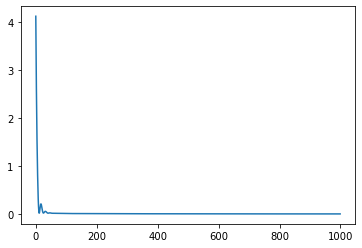

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)
#plt.plot(loss_history_n3[10:])

In [38]:
import pandas as pd
import seaborn as sns



def plot_geom_eval(a,b,mode="bond",s=0.01):
  

    
  fig, axs = plt.subplots(1,2,figsize=(16,5))
  axs = axs.flatten()
  
  # scatter plot
  ax = axs[0]
  ax.scatter(a,b,s=s)
  #sns.kdeplot(a,b,fill=True)
  if mode == "bond":
    ax.set_xlim(1,1.8)
    ax.set_ylim(1,1.8)
  elif mode == "angle":
    ax.set_xlim(50,140)
    ax.set_ylim(50,140)
  ax.plot([0,200],[0,200],color="black")
  ax.set_xlabel("Experimental",fontsize=14)
  
  # historgram
  ax = axs[1]
  sns.histplot(a-b,ax=ax,kde=True,stat="density")
  if mode == "bond":
    ax.set_xlim(-3,3)
  elif mode == "angle":
    ax.set_xlim(-20,20)


In [39]:
a,b = g.nodes[frag_name].data["eq"],g.nodes[frag_name].data["ref"]
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
#a,b = to_np(a).flatten(),to_np(b).flatten()

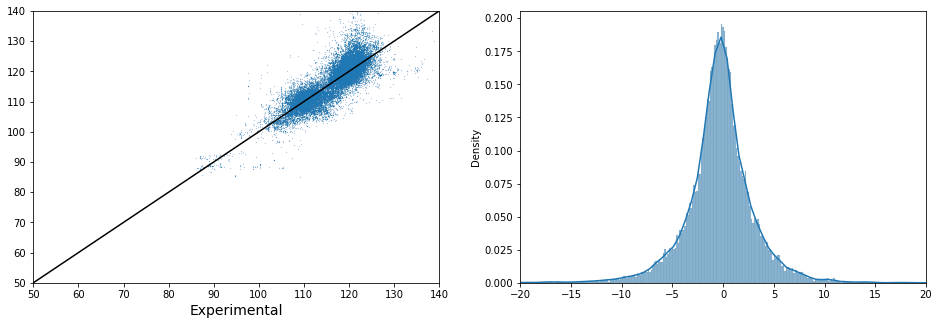

In [40]:
plot_geom_eval(a,b,s=0.005,mode="angle")

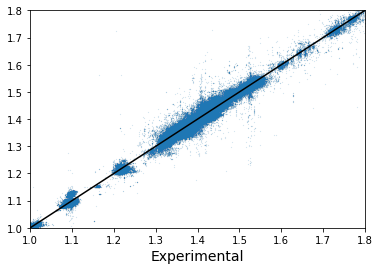

In [30]:
a,b = g.nodes["fragment"].data["pred"],g.nodes["fragment"].data["ref"]
plot_geom_eval(a,b,s=0.001)

In [43]:
batch.etypes

['atom_as_0_in_fragment',
 'atom_as_1_in_fragment',
 'atom_as_2_in_fragment',
 'atom_connects_atom']

In [44]:
batch.nodes["fragment"].data.keys()

dict_keys(['idxs', 'ref', 'h0', 'h1', 'h2', 'pred'])